In [13]:
import os
import h5py
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
data_dir='ATL06/Byrd_glacier_rel001/'

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


# make sure we're dealing with the most recent version of any code we're using
%load_ext autoreload
%autoreload 2

# Clouds over land ice: What problems they cause, and what to do about it.
This tutorial covers some of the reasons you might see weird results over ice when clouds start to blot out the surface signals.  The learning objectives I'd like to get to are:
- Understanding how clouds affect laser-altimetry signals
- Recognizing how these effects are manifest in the ATL06 product
- Gaining familiarity with the ATL06 parameters that can identify cloudy returns
This part of the tutorial will focus on clouds that cause gross errors in surface-height estimates.  

Along the way, we'll:

- develop a simple function for reading ICESat-2 data from hdf-5 files

If time allows, I'll also present on subtler effects caused by forward scattering of laser light by thin clouds, which can lead to smaller elevation biases.  The objectives of this part of the tutorial will be:
- Understanding how forward scattering of laser light by clouds can introduce biases in surface-height estimates
- Tools for identifying returns affected by forward scattering.

Preliminary matters:  
I've pulled the ICESat-2 data for the Byrd Glacier catchment, and it's stored on S3, so you can grab it with these commands:

    aws s3 cp s3://pangeo-data-upload-oregon/icesat2/Clouds_and_filtering_tutorial/ATL06 /home/jovyan/ATL06 --recursive
    aws s3 cp s3://pangeo-data-upload-oregon/icesat2/Clouds_and_filtering_tutorial/ATL03 /home/jovyan/ATL03 --recursive


## 1.  Introduction: Signals and signal finding.

<img src="images/Four_photon_paths.jpg"  width=600 height=600>

The photons that we see in ATLAS data can come to the receiver in a few different ways.  
--(A, B): The majority of photons come from the sun.   These may reflect off clouds or off the land surface, and they arrive with a uniform random distribution. ATLAS does a good job of filtering these out, but some make it through into the data.  
--C: A few are ATLAS laser photons reflected off clouds.  These can be loosely clustered in space, or widely spread out like background photons.  
--D, E: Some are ATLAS photons that reflect off the surface.  These are the ones that most of us are interested in.

Our challenge is to collect and analyze D and E, without getting confused by A, B, or C.  Part of the challenge is that there are many photons from ATLAS that end up in category F: photons that are scattered away by clouds, and never seen again.

There are three stages that determine whether a surface in a higher-level product like ATL06.
1. The ATLAS on-board algorithm may or may not decide to telemeter a photon.  ATLAS doesn't have a lot of computing power, and it can't transmit every photon to the surface.  It uses a coarse DEM and some simple rules to decide whether to transmit large blocks of data to the surface.  If it can't find an obvious group of photons from the surface, it usually transmits the strongest block of photons it finds.  This often works well.
2. ATL03 uses a surface-type-dependent algorithm to search for spatially-extensive clusters of photons, and marks them in the _signal_confidence_ flags.  This mostly works very well.
3. ATL06 uses the ATL03 signal confidence flags, when they are available, to find the surface.  If this fails, ATL06 uses a backup signal finder to try to find the surface that ATL03 missed.  

If we look at an ATL03 we will see all of the photons that ATLAS telemetered to the ground, and we will see the results of ATL03 ground finding.  If we look at an ATL06, we will see the heights of segments for which ATL06 decided that there were enough photons that it might have detected the ground. We will look at some data to try to understand how these processes worked.


### 1.1 ATL06 signal processing

<img src="images/ATL06_segment_model.png"  width=600 height=600>

Recall that ATL06 gives us surface heights based on the heights of collections of photons in a 40-m (horizontal) by w_surface_window (vertical) window.  It uses a variety of techniques to shrink the window to the smallest size that contains the surface without clipping off any signal photons.  


There's a general philosophy that went into the design of ATL06:
1. Use the best available information to identiy the surface
2. If there's a chance that we've found a weak surface return, report it
3. Provide enough parameters that users can decide which returns are worth using, and which are not

When there are no thick clouds between ICESat-2 and the surface, finding the surface return and reporting its height is straightforward: ATL03 provides a tight cluster of high-confidence photons, and ATL06 calculates a weighted average of their heights.

Once clouds start to block some of the laser light, the number of photons that return to ATLAS from each return becomes progressively smaller.  Unfortunately, even if there are no laser photons to measure, during daylight there is no shortage of other photons to track.  ATLAS does a very good job of filtering out almost all of these photons, but on a sunny day, over a white surface, the measured background rate can be as high as 12 MHz.  Converting to dimensions that we'll be seeing this is:
$$ 
    \frac{1.2\times10^7 photons}{second} \times \frac{1 second}{1.5\times10^8 m} = \frac{1 photon}{12.5 m}
$$
This doesn't sound like a lot, but over a 10-meter-high window that's 40 m long (typical for the kind of windows you might use to look for the surface if you didn't know where to find it) we can expect to find 45 photons.

Unlike surface-return photons, background photons are uniformally distributed in height, and any clustering of these photons will be due to random chance.  When the signal quality is marginal, ATL03 may flag photons only as low- and medium- confidence for a particular segment, or may flag no photons at all.  If ATL03 hasn't told ATL06 which photons are the surface, the algorithm uses a backup signal-finding strategy that initializes surface finding using the strongest cluster of photons available.  It then attempts to converge its surface window on a tight cluster of photons.  This occasionally works, but if there really is no signal, the size of the window generally remains large, and we can evaluate the results based on the signal-to-noise ratio (SNR) of whatever ends up inside the window.  Only those segments with at least 10 photons, for which the probability of converging to an SNR equal to the observed SNR or better for random-noise inputs is less thatn 5% are reported.  This cuts down on false positives considerably.  

## 2. A look at ATL03 over Byrd Glacier

This part of the tutorial is possible thanks to a function provided by Tyler Sutterly \[stand up, Tyler\].

To get an idea of how this works, we'll read in an ATL03 granule over Byrd Glacier in East Antarctica.  We'll use a reader that we import from an external Python file (readers/read_HDF5_ATL03.py, and a helper function, /readers/get_ATL03_x_atc.py), and plot the results using Matplotlib.  ATL03 is a complicated product, and reading it takes quite a few lines of code.  Please feel free to look at Tyler's code, and ask him questions about it.  We won't cover this in detail during the tutorial.

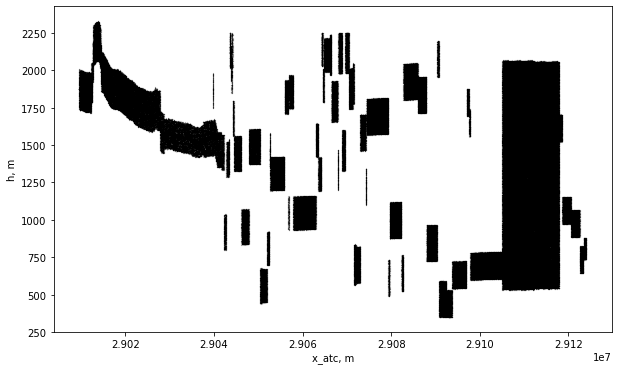

In [55]:
from readers.read_HDF5_ATL03 import read_HDF5_ATL03
from readers.get_ATL03_x_atc import get_ATL03_x_atc

# read the IS2 data with Tyler's ATL03 reader:
ATL03_file=glob('/home/jovyan/ATL03/Byrd_Glacier_rel001/*.h5')
IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams =read_HDF5_ATL03(ATL03_file[0])

# add x_atc to the ATL03 data structure (this function adds to the LS2_ATL03_mds dictionary)
get_ATL03_x_atc(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams)

#-- select the 1r beam from ATL03
D3 = IS2_atl03_mds['gt1r']

#-- create scatter plot of photon data (e.g., photon elevation vs x_atc)
%matplotlib inline
f1,ax = plt.subplots(num=1,figsize=(10,6))
plt.plot(D3['heights']['x_atc'], D3['heights']['h_ph'],'k.',markersize=0.1)
ax.set_xlabel('x_atc, m')
ax.set_ylabel('h, m')
plt.show()

A couple of things to notice. First, the width of this plot is about 120 km, and its height(top to bottom) is about 2 km.  We're looking at large structures here.  Second, This is mostly a plot of background photon heights. The black shapes here represent the top and bottom of the ATLAS telemetry window, so it's showing what the simple electronics on board the satellite identified as potentially coming from the surface. You can see that the ATLAS signal finder has locked onto something on the left-hand side of the plot (up to around $2.904\times 10^7 m$), then it loses track of the surface in the middle of the plot between 2.904 and $2.910\times 10^7 m$ and reports its best guess, then maybe picks the surface up again around $2.910\times 10^7 m$.  We can get a better idea of these by zooming in on a couple of regions:

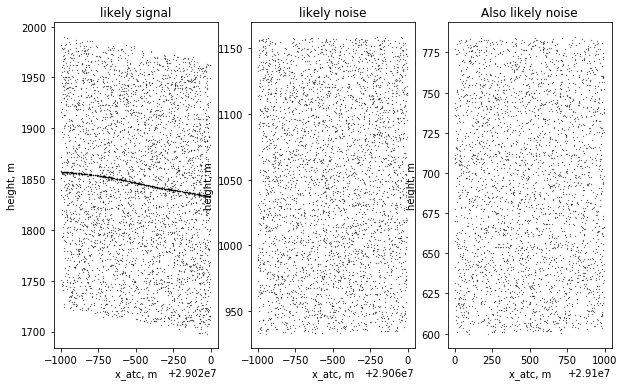

In [56]:
# pick some subsets of the data.  These are logical arrays- what's marked as true in these arrays will get plotted, what's not will be ignored
subset1=(D3['heights']['x_atc'] > 2.90190e7) & ((D3['heights']['x_atc'] < 2.902e7) )
subset2=(D3['heights']['x_atc'] > 2.90590e7) & ((D3['heights']['x_atc'] < 2.906e7) )
subset3=(D3['heights']['x_atc'] > 2.910e7) & ((D3['heights']['x_atc'] < 2.9101e7) )

f1,ax = plt.subplots(1, 3,figsize=(10,6))
ax[0].plot(D3['heights']['x_atc'][subset1], D3['heights']['h_ph'][subset1],'k.',markersize=0.5)
ax[0].set_xlabel('x_atc, m')
ax[0].set_ylabel('height, m')
ax[0].set_title('likely signal')
plt.axes(ax[1])
ax[1].plot(D3['heights']['x_atc'][subset2], D3['heights']['h_ph'][subset2],'k.',markersize=0.5)
ax[1].set_xlabel('x_atc, m')
ax[1].set_ylabel('height, m')
ax[1].set_title('likely noise')
plt.axes(ax[2])
ax[2].plot(D3['heights']['x_atc'][subset3], D3['heights']['h_ph'][subset3],'k.',markersize=0.5)
ax[2].set_xlabel('x_atc, m')
ax[2].set_ylabel('height, m')
ax[2].set_title('Also likely noise')

plt.show()

It looks like our guess that the area on the left-hand side of the plot was signal was right, but the regions we picked from the middle and right-hand side of the plot only contain noise.  This is not a very good way of looking at data.  ATL03 has automatic signal finders that do a good job of identifying the surface.  Here's what they look like for this granule:

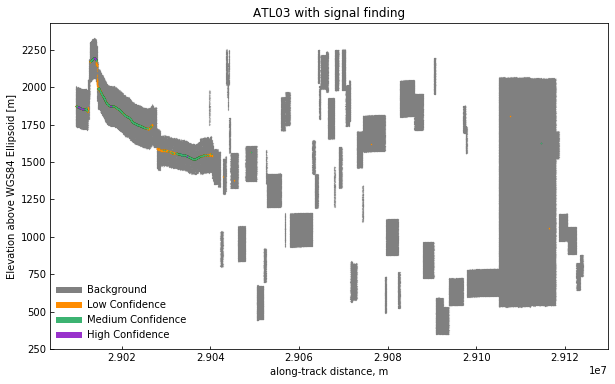

In [59]:
f1,ax = plt.subplots(num=1,figsize=(10,6))


#-- check confidence level associated with each photon event
#-- -1: Events not associated with a specific surface type
#--  0: noise
#--  1: buffer but algorithm classifies as background
#--  2: low
#--  3: medium
#--  4: high
#-- Signal classification confidence for land ice
#-- 0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
ice_sig_conf = D3['heights']['signal_conf_ph'][:,3]
#-- background and buffer photons
bg, = np.nonzero((ice_sig_conf == 0) | (ice_sig_conf == 1))
lc, = np.nonzero(ice_sig_conf == 2)
mc, = np.nonzero(ice_sig_conf == 3)
hc, = np.nonzero(ice_sig_conf == 4)
#-- Photon event delta time and elevation (WGS84)
ax.plot(D3['heights']['x_atc'][bg],D3['heights']['h_ph'][bg],marker='.',
    markersize=0.1,lw=0,color='gray',label='Background')
ax.plot(D3['heights']['x_atc'][lc],D3['heights']['h_ph'][lc],marker='.',
    markersize=0.25,lw=0,color='darkorange',label='Low Confidence')
ax.plot(D3['heights']['x_atc'][mc],D3['heights']['h_ph'][mc],marker='.',
    markersize=0.25,lw=0,color='mediumseagreen',label='Medium Confidence')
ax.plot(D3['heights']['x_atc'][hc],D3['heights']['h_ph'][hc],marker='.',
    markersize=0.25,lw=0,color='darkorchid',label='High Confidence')
#-- set title and labels
ax.set_xlabel('along-track distance, m')
ax.set_ylabel('Elevation above WGS84 Ellipsoid [m]')
ax.set_title("ATL03 with signal finding")
#-- create legend
lgd = ax.legend(loc=3,frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
#-- adjust ticks
ax.get_xaxis().set_tick_params(which='both',direction='in')
ax.get_yaxis().set_tick_params(which='both',direction='in')
#-- show the plot
plt.show()



Clusters of photons are great, but they don't tell you how high the surface is.  ATL06 is where we want to go for that.  Because the ATL06 product is simpler, we can write a fairly simple function that reads useful data into a dictionary.  The code is stored in readers/ATL06_to_dict.py, but we can also look at it in Jupyter:

In [ ]:
import numpy as np
import h5py


def ATL06_to_dict(filename, dataset_dict):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            dataset_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a list of numpy arrays containing the 
                data
    """
    
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']
    # open the HDF5 file
    with h5py.File(filename) as h5f:
        # loop over beam pairs
        for pair in pairs:
            # loop over beams
            for beam_ind, beam in enumerate(beams):
                # check if a beam exists, if not, skip it
                if '/gt%d%s/land_ice_segments' % (pair, beam) not in h5f:
                    continue
                # loop over the groups in the dataset dictionary
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        # since a dataset may not exist in a file, we're going to try to read it, and if it doesn't work, we'll move on to the next:
                        try:
                            temp[dataset]=np.array(h5f[DS])
                            # some parameters have a _FillValue attribute.  If it exists, use it to identify bad values, and set them to np.NaN
                            if '_FillValue' in h5f[DS].attrs:
                                fill_value=h5f[DS].attrs['_FillValue']
                                temp[dataset][temp[dataset]==fill_value]=np.NaN
                        except KeyError as e:
                            pass
                if len(temp) > 0:
                    # it's sometimes convenient to have the beam and the pair as part of the output data structure: This is how we put them there.
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

The function returns a list of dictionary objects, where each dictionary contains the variables in the ATL06 product.  To tell the reader which variables to read, we just provide a dictionary that tells it where to look in the file (which groups to read) and what variables to read from each group.  Were going to read:
- /gtxx/land_ice_segments/h_li   : the land-ice height.
- /gtxx/land_ice_segments/delta_time : the time of the segment.
- /gtxx/land_ice_segments/ground_track/x_atc  : the along-track coordinate of the segment.

We define the dictionary that tells the function what to read like this:

In [ ]:
dataset_dict={'land_ice_segments':['h_li', 'delta_time'], 'land_ice_segments/ground_track':['x_atc']}

... and then we use the reader function like this:

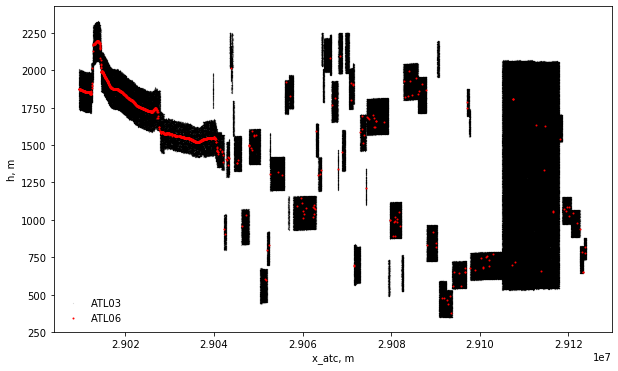

In [63]:

# read ATL06 into a dictionary (the ATL06 file has the same name as the ATL03 file, except for the product name)
ATL06_file=ATL03_file[0].replace('ATL03', 'ATL06')
D6_list=ATL06_to_dict(ATL06_file, dataset_dict)

# pick out gt1r:
D6 = D6_list[1]

# plot ATL03, with ATL06 on top:
f1,ax = plt.subplots(num=1,figsize=(10,6))
ax.plot(D3['heights']['x_atc'], D3['heights']['h_ph'],'k.',markersize=0.1, label='ATL03')
ax.plot(D6['x_atc'], D6['h_li'],'r.', markersize=2, label='ATL06')
lgd = ax.legend(loc=3,frameon=False)

ax.set_xlabel('x_atc, m')
ax.set_ylabel('h, m')
plt.show()


What we see here is that ATL06 found the surface in the same places that ATL03 did, but also reported heights in some of the noise-only areas. This is a consequence of attempting to find surfaces under marginal conditions.  

In [67]:
num_bad_segments=np.sum((D6['x_atc'] > 2.904e7) & (D6['x_atc'] < 2.912e7) & np.isfinite(D6['h_li']))
num_possible_segments=(2.912e7 - 2.904e7)/20
F_bad=num_bad_segments/num_possible_segments
print("fraction of bad segments = %3.3f" % F_bad)

fraction of bad segments = 0.043


The signal-to-noise threshold on ATL06 is supposed to let through about 5% of noise-only segments.  If we assume that everything beyond $2.094\times 10^7 m$ is noise, we find that ATL06 found a (bad) height about 4% of the time.  We'll work on cleaning these up in the next sections.

## 3. Relating cloud effects to ATL06 data parameters

Our problem comes when the ground return is not strong enough to trigger the signal finder, and we start to see triggers associated with:
- Cloud tops
- Random clusterings of background photons

These should both be statistically distinct from surface returns because:
- The returns are less intense than a high-quality surface return
- The photons are more widely vertcally spread than those in surface returns
- The surface window cannot converge on a small vertical window around the surface
- Surface heights and slopes are not consistent between adjacent segments

There are a few ATL06 parameters that help quantify these distinctions. 
In the /gtxx/land_ice_segments group:
- h_li_sigma : the estimated error in the surface-height estimate
In the /gtxx/land_ice_segments/fit_statistics groups:
- n_fit_photons : The number of photons found in each segment
- w_surface_window_final : The size of the converged surface window
- h_rms_misft : The RMS misfit of photons in the surface window
- h_robust_sprd : A percentile-based estimate of the spread of the photons, corrected for background
- snr : the observed signal-to-noise ratio for the selected photons
- snr_significance : The estimated probability that a random clustering of photons would produce the observed SNR
- dh_fit_dx : the along-track segment slope
And in /gtxx/land_ice_segments/geophysical:
- r_eff : the effective reflectance of the surface

There's one more parameter that puts a few of these ideas together, in /gtxx/land_ice_segments:
- atl06_quality_summary : a combination of parameters (h_li_sigma, n_fit_photons/w_surface_window_final, and signal_selection_source).  Zero indicates a good segment, 1 indicates a possibly bad segment.


### 3.1 Taking our picture of cloud effects to the ice sheet
We're next going to look at data from Byrd Glacier, in Antarctica.  This is one of the big outlet glaciers dumping ice from the East Antarctic plateau into the Ross Ice Shelf.  Here's a shaded-relief map from the REMA.
<img src="https://www.gislounge.com/wp-content/uploads/2018/09/mulock-glacier-dem.jpg">

The glacier flows west to east (the REMA image is south-end-up, so east is on the left).  The inland catchment of the glacier should have a smooth ice surface, but the glacier trunk and the area where it joins the ice shelf are heavily crevassed.

The dataset on AWS contains a large number of granules that I found with a spatial search using an NSIDC data query.  We can use matplotlib's scatter() function to make a map of all the elevations from all of these files.

In [105]:
# NOTE: From now on, we'll be working in matplotlib's widget mode, which lets us zoom in on our plots.  
# This means that the figures won't be rendered in the notebook until you run them.
# That means no more spoiler plots (for now...)
%matplotlib widget


data_dir='/home/jovyan/ATL06/Byrd_Glacier_rel001/'
D6=[]
pairs=[1, 2, 3]
beams=['l','r']

files=glob(data_dir+'/*.h5')
for file in files:
    this_name=os.path.basename(file)
    D6 += ATL06_to_dict(file, dataset_dict)
print("read %d beam/pair combinations" % (len(D6)))

# now plot the results:
plt.figure();
for Di in D6:
    plt.scatter(Di['longitude'], Di['latitude'], c=Di['h_li'], vmin=0, vmax=2000, linewidth=0)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

read 528 beam/pair combinations


FigureCanvasNbAgg()

This plot is opposite the orientation of the REMA map, but we can see the trunk of the glacier (dark blue, right-center) and we can see the East Antarctic plateau (bright yellow, at left).


Let's look at a few granules as plots of height against along-track distance:

In [106]:
dataset_dict={'land_ice_segments':['latitude','longitude','h_li'], 'land_ice_segments/ground_track':['x_atc']}

%matplotlib widget
for file in files[0:3]:
    this_D6=ATL06_to_dict(file, dataset_dict)
    plt.figure()
    plt.plot(this_D6[1]['x_atc'], this_D6[1]['h_li'],'.')
    plt.title(this_D6[1]['filename'])

FigureCanvasNbAgg()

FigureCanvasNbAgg()

FigureCanvasNbAgg()

### Participant exercise:

Let's split up into groups for a few minutes, and have a look through these granules.  Try to find some examples with 
- Clouds
- Really steep surface slopes
- Crevasses


In [15]:
# Workspace

In [84]:
# here are some of the files that I picked out as interesting:

example_file_indices=[3, 1, 5]

In [107]:
# first example
D6=ATL06_to_dict(files[example_file_indices[0]], dataset_dict)
markers=['.','+']
plt.figure()
for ind, seg in enumerate(D6[0:2]):     
    plt.plot(seg['x_atc'], seg['h_li'],marker=markers[ind], color='k', linestyle='')
    plt.title(seg['filename'])
    

FigureCanvasNbAgg()

This is our old friend, with good quality on the left, and bad quality on the right.  The weak beam of pair 1 is plotted with points, the strong beam is plotted with plusses- clearly having four times fewer photons in the weak beam doesn't give better results.

In [108]:
D6=ATL06_to_dict(files[example_file_indices[1]], dataset_dict)
markers=['.','+']
plt.figure()
for ind, seg in enumerate(D6[0:2]):     
    plt.plot(seg['x_atc'], seg['h_li'],marker=markers[ind], color='k', linestyle='')
    plt.title(seg['filename'])

FigureCanvasNbAgg()

This one is more interesting.  The quality is generally high, but there are a few places where the surface disappears and there are outliers

In [109]:
D6=ATL06_to_dict(files[example_file_indices[2]], dataset_dict)
markers=['.','+']
plt.figure()
for ind, seg in enumerate(D6[0:2]):     
    plt.plot(seg['x_atc'], seg['h_li'],marker=markers[ind], color='k', linestyle='')
    plt.title(seg['filename'])

FigureCanvasNbAgg()

This one worked well. ATL06 maintained a good lock on the surface across some very rugged terrain, with no significant false detections.

### Participant exercise:
Look at the Byrd Glacier profiles.  
- Use the matplotlib scatter function to plot the parameters as a function of x_atc and h_li, and see which parameters correspond to good returns, which correspond to clouds.
- See which returns are lost if we use the parameter as a threshold

In [110]:
# Example:  
dataset_dict['/land_ice_segments/fit_statistics']=['h_rms_misfit']
D6=ATL06_to_dict(files[example_file_indices[0]], dataset_dict)
plt.figure()
plt.subplot(121)
plt.scatter(D6[0]['x_atc'], D6[0]['h_li'], c=D6[0]['h_rms_misfit'], linewidth=0); plt.colorbar()
plt.subplot(122)
good=np.where(D6[0]['h_rms_misfit'] < .5)[0]
plt.plot(D6[0]['x_atc'][good], D6[0]['h_li'][good],'.')

FigureCanvasNbAgg()

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


Once you have picked out a set of filtering parameters you like, compare the results with the atl06_quality_summary. Do you have anything you like better?  Regenerate the plot from the top of this section where we mapped the heights for Byrd Glacier using plt.scatter()

There is one more way of flagging bad data that we can try, that can help clean up the remaining bad segments.  Recall that the the ATL06 data model fits both the height and the surface slope of segments: 

<img src="images/dh_segment.png"  width=500 height=450>

Let's look at the segments including their slopes:

In [111]:
def seg_slope_plot(D6):
    """
    Plot a sloping line for each ATL06 segment
    """
    #define the heights of the segment endpoints.  Leave a row of NaNs so that the endpoints don't get joined
    h_ep=np.zeros([3, D6['h_li'].size])+np.NaN
    h_ep[0, :]=D6['h_li']-D6['dh_fit_dx']*20
    h_ep[1, :]=D6['h_li']+D6['dh_fit_dx']*20
    # define the x coordinates of the segment endpoints
    x_ep=np.zeros([3,D6['h_li'].size])+np.NaN
    x_ep[0, :]=D6['x_atc']-20
    x_ep[1, :]=D6['x_atc']+20

    plt.plot(x_ep.T.ravel(), h_ep.T.ravel())

In [112]:
# to try this, we'll need to add dh_fit_dx to the data dictionary:
dataset_dict['land_ice_segments/fit_statistics']=['dh_fit_dx']

D6=ATL06_to_dict(files[example_file_indices[0]], dataset_dict)
markers=['.','+']
plt.figure()
for ind, seg in enumerate(D6[0:2]):     
    seg_slope_plot(seg)
    plt.title(seg['filename'])

FigureCanvasNbAgg()

When we zoom in we can see that the "smooth" section is a little messy (maybe crevassed), but that the slopes in the cloudy section are really big.  We can use this to define a new filtering strategy that can delete some of the worst segments:

In [113]:
def seg_difference_filter(D6, tol=2):
    """
    seg_difference_filter: Use elevations and slopes to find bad ATL06 segments
    
    
    Inputs: 
        D6: a granule of ATL06 data, in dictionary format.  Must have entries:
            x_atc, h_li, dh_fit_dx
        tol: a tolerance.  Segments whose ends are different from their neighbors 
             by more than tol are marked as bad
    Returns:
        good: an array the same size as D6['h_li'].  True  entries indicate that 
            both ends of the segment are compatible with the segment's neighbors
        delta_h_seg: an array the same size as D6['h_li'].  Gives the largest 
            endpoint difference for each segment    
    """
    h_ep=np.zeros([2, D6['h_li'].size])+np.NaN
    h_ep[0, :]=D6['h_li']-D6['dh_fit_dx']*20
    h_ep[1, :]=D6['h_li']+D6['dh_fit_dx']*20
    delta_h_seg=np.zeros_like(D6['h_li'])
    delta_h_seg[1:]=np.abs(D6['h_li'][1:]-h_ep[1, :-1])
    delta_h_seg[:-1]=np.maximum(delta_h_seg[:-1], D6['h_li'][:-1]-h_ep[0, 1:])
    good=delta_h_seg < tol
    return good, delta_h_seg


### Participant Exercise: 
Try out the seg_difference_filter.  Generate a finalized map of elevations for Byrd Glacier

In [24]:
##Workspace

# Summary of this part of the tutorial:  
- Clouds tend to produce weaker-than-normal returns
- We can identify low-quality surface returns with a variety of parameters.  

## 2.3 Errors due to forward scattering of photons.

A more insidious problem that clouds can cause comes about when an optically thin cloud lets photons through, but some of the photons scatter off ice grains in the forward (downward) direction and hit the surface before returning to the telescope.

<img src="images/Forward_scattering.png"  width=600 height=600>

The path for a photon that reaches the surface without hitting the cloud is shown in blue, the path of a scattered photon is shown in red.  Since photons are delayed by a small but random amount whose distribution depends on the height and thickness of the cloud, the expected probability distibution of the scattered photon heights is skewed low (shown in schematic at left), and the mean (or median) photon height has a negative bias. 

When clouds are high above the ground, most scattered photons end up outside the telescope field of view, and don't do much to skew the return distribution.  It's when clouds are low that more scattered photons are detected, and the bias can become large.  For this reason, Yeukui Yang has put together a set of parameters aimed at flagging segments most strongly affected by forward scattering.  These are in the ATL06 _/gtxx/land_ice_segments/geophysical_ group:

There are two cloud parameters:
- cloud_flg_asr  : an estimate of the presence/ absence of clouds based on the apparent surface reflectance (low reflectance -> possible clouds)
- cloud_flg_atm  : An estimate of the presence / absence of clouds based on backscatter above the surface.  This parameter only gives useful values at night, because during the daytime there is too much solar background to see clouds

There are three blowing-snow parameters:
- bsnow_h : An estimate of the height of the top of any blowing-snow layers present
- bsnow od : An estimate of the optical depth of a blowing-snow layer (if present )
- bsnow_conf : A confidence flag for the presence / absence of a blowing-snow layer.

And there is a combined flag that summarizes what has been learned from the atmospheric channels:
- msw_flag: "Combined flag indicating the risks of severe multiple scattering. The multiple scattering warning flag (ATL09 parameter msw_flag) has values from -1 to 5 where zero means no multiple scattering and 5 the greatest. If no layers were detected, then msw_flag = 0. If blowing snow is detected and its estimated optical depth is greater than or equal to 0.5, then msw_flag = 5. If the blowing snow optical depth is less than 0.5, then msw_flag = 4. If no blowing snow is detected but there are cloud or aerosol layers detected, the msw_flag assumes values of 1 to 3 based on the height of the bottom of the lowest layer: < 1 km, msw_flag = 3; 1-3 km, msw_flag = 2; > 3km, msw_flag = 1. A value of -1 indicates that the signal to noise of the data was too low to reliably ascertain the presence of cloud or blowing snow. We expect values of -1 to occur only during daylight."

The long block quote here comes from the product description in ATL06.

The algorithms behind these parameters still being refined by the atmosphere team, so it's not certain that they produce good results.  As an exercise for the group, let's split into groups, and map the values for these parameters to see if any of them produce good-looking results over Byrd Glacier.


### Participant Exercise: 
Investigate cloud-filtering parameters over Byrd Glacier.  User the Matplotlib _scatter_ function to map the distribution of the cloud and blowing-snow flags.  

In [ ]:
## workspace